# Tests for Scenario 2

imports

In [1]:
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver
from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting
import matplotlib.pyplot as plt # plot data and results

### Get data from excel

In [3]:
data = './datasets/Stephan_pH7.xlsx'
df = pd.read_excel(data)
#print(df)

### Convert dataframe to np-array

In [4]:
data_time = df[df.columns[0]].to_numpy(np.float64)
print(data_time)
data_s = df[df.columns[1]].to_numpy(np.float64)
print(data_s)

[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.         2.08333333 2.16666667 2.25       2.33333333 2.41666667
 2.5        2.58333333 2.66666667 2.75       2.83333333 2.91666667
 3.         3.08333333 3.16666667 3.25       3.33333333 3.41666667
 3.5        3.58333333 3.66666667 3.75       3.83333333 3.91666667
 4.         4.08333333 4.16666667 4.25       4.33333333 4.41666667
 4.5        4.58333333 4.66666667 4.75       4.83333333 4.91666667]
[0.9862 0.9734 0.9734 0.9666 0.9403 0.9353 0.9137 0.903  0.8932 0.8748
 0.8651 0.8453 0.8308 0.817  0.7955 0.7839 0.7665 0.7448 0.7251 0.7068
 0.688  0.665  0.6449 0.6267 0.6079 0.5852 0.5643 0.546  0.5259 0.5044
 0.4838 0.4647 0.4419 0.4202 0.3998 0.38   0.358  0.3403 0.3208 0.3027
 0.2828 0.264  0.2484 0.2317 0.2155 0.1998 0.

## Fit data to system of odes

### define the ode functions

In [5]:
def f(w, t, paras):
    '''
    System of differential equations
    Arguments:
        w: vector of state variables: w = [v,s]
        t: time
        params: parameters
    '''
    v, s = w
    
    try:
        a = paras['a'].value
        vmax = paras['vmax'].value
        km = paras['km'].value

    except KeyError:
        a, vmax, km = paras
    
    
    # f(v',s'):
    f0 = a*(vmax-v) # v'
    f1 = -v*s/(km+s) # s'
    return [f0,f1]

In [6]:
# WITH BIAS
def f_b(w, t, paras):
    '''
    System of differential equations
    Arguments:
        w: vector of state variables: w = [v,s]
        t: time
        params: parameters
    '''
    v, s = w
    
    try:
        a = paras['a'].value
        vmax = paras['vmax'].value
        km = paras['km'].value
        b = paras['b'].value

    except KeyError:
        a, vmax, km, b = paras
    
    
    # f(v',s'):
    f0 = a*(vmax-v) # v'
    f1 = -v*(s+b)/(km+s+b) # s'
    return [f0,f1]

### Solve ODE

In [7]:
def g(t, w0, paras):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [v0, s0])
    '''
    w = odeint(f, w0, t, args=(paras,))
    return w

In [8]:
# WITH BIAS
def g_b(t, w0, paras):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [v0, s0])
    '''
    w = odeint(f_b, w0, t, args=(paras,))
    return w

### compute residual between actual data (s) and fitted data

In [9]:
def residual(paras, t, data_s):
    w0 = paras['v0'].value, paras['s0'].value
    model = g(t, w0, paras)
    # only have data for s not v
    s_model = model[:,1]
    return (s_model- data_s).ravel()

In [10]:
# WITH BIAS
def residual_b(paras, t, data_s):
    w0 = paras['v0'].value, paras['s0'].value
    model = g_b(t, w0, paras)
    # only have data for s not v
    s_model = model[:,1]
    bias = paras['b'].value
    s_model_b = s_model + bias
    return (s_model_b - data_s).ravel()

In [11]:
# WITH fixed BIAS
def residual_bf(paras, t, data_s):
    w0 = paras['v0'].value, paras['s0'].value
    model = g(t, w0, paras)
    # only have data for s not v
    s_model = model[:,1]
    bias = paras['b'].value
    s_model_b = s_model + bias
    return (s_model_b - data_s).ravel()

### Bringing all together

In [12]:
# initial conditions:
v0 = 0
s0 = data_s[0]
w0 = [v0,s0]
# 0,970877378


# measured data
t_measured = data_time
s_measured = data_s

In [13]:
# WITH BIAS
# initial conditions:
v0_b = 0
s0_b = 0.861847366499791
w0_b = [v0_b,s0_b]

In [14]:
# Set parameters including bounds
params = Parameters()
params.add('v0', value=v0, vary=False)
params.add('s0', value=s0, vary=False)
params.add('a', value=1., min=0.0001, max=2.)
params.add('vmax', value=0.2, min=0.0001, max=1.)
params.add('km', value=0.05, min=0.0001, max=1.)
#params.add('km', value=0.05, vary=False)

In [15]:
# WITH BIAS
# Set parameters including bounds
params_b = Parameters()
params_b.add('v0', value=v0_b, vary=False)
params_b.add('s0', value=s0_b, vary=False)
params_b.add('a', value=1., min=0.0001, max=2.)
params_b.add('vmax', value=0.2, min=0.0001, max=1.)
params_b.add('km', value=0.05, min=0.0001, max=1.)
#params_b.add('km', value=0.05, vary=False)
#params_b.add('b', value=0.1, min=0.01, max=0.5)
params_b.add('b', value=0.109, vary=False)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 60
    # variables        = 3
    chi-square         = 0.01045809
    reduced chi-square = 1.8348e-04
    Akaike info crit   = -513.283455
    Bayesian info crit = -507.000422
[[Variables]]
    v0:    0 (fixed)
    s0:    0.9862 (fixed)
    a:     1.50226977 +/- 0.16983479 (11.31%) (init = 1)
    vmax:  0.39214515 +/- 0.03741561 (9.54%) (init = 0.2)
    km:    0.28910462 +/- 0.05745140 (19.87%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, km) =  0.989
    C(a, vmax)  = -0.949
    C(a, km)    = -0.897


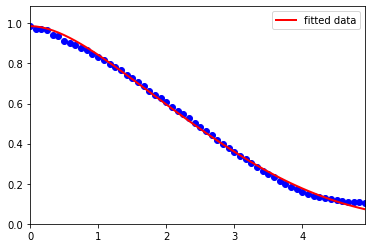

In [16]:
# fit model
result = minimize(residual, params, args=(t_measured, s_measured), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(t_measured, w0, result.params)

# plot fitted data
plt.plot(t_measured, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])
# display fitted statistics
report_fit(result)

plt.scatter(t_measured, s_measured, marker='o', color='b', label='measured substrate')
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 60
    # variables        = 3
    chi-square         = 0.00732127
    reduced chi-square = 1.2844e-04
    Akaike info crit   = -534.678951
    Bayesian info crit = -528.395917
[[Variables]]
    v0:    0 (fixed)
    s0:    0.8618474 (fixed)
    a:     1.06527018 +/- 0.12971569 (12.18%) (init = 1)
    vmax:  0.48245218 +/- 0.06391023 (13.25%) (init = 0.2)
    km:    0.40123596 +/- 0.08668977 (21.61%) (init = 0.05)
    b:     0.109 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, km) =  0.993
    C(a, vmax)  = -0.972
    C(a, km)    = -0.940


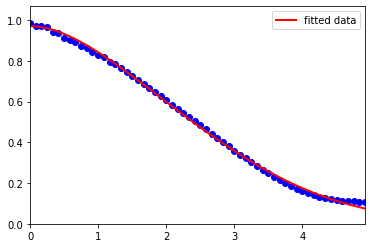

In [17]:
# fit model
result_b = minimize(residual_b, params_b, args=(t_measured, s_measured), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted_b = g_b(t_measured, w0_b, result_b.params)

# plot fitted data
plt.plot(t_measured, data_fitted_b[:, 1]+params_b['b'].value, '-', linewidth=2, color='red', label='fitted data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted_b[:, 1]+params_b['b'].value)])
# display fitted statistics
report_fit(result_b)

plt.scatter(t_measured, s_measured, marker='o', color='b', label='measured substrate')
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 60
    # variables        = 3
    chi-square         = 0.00732127
    reduced chi-square = 1.2844e-04
    Akaike info crit   = -534.678951
    Bayesian info crit = -528.395917
[[Variables]]
    v0:    0 (fixed)
    s0:    0.8618474 (fixed)
    a:     1.06527018 +/- 0.12971569 (12.18%) (init = 1)
    vmax:  0.48245218 +/- 0.06391023 (13.25%) (init = 0.2)
    km:    0.40123596 +/- 0.08668977 (21.61%) (init = 0.05)
    b:     0.109 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, km) =  0.993
    C(a, vmax)  = -0.972
    C(a, km)    = -0.940


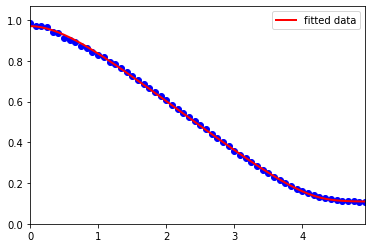

In [18]:
# fit model
result_bf = minimize(residual_bf, params_b, args=(t_measured, s_measured), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted_bf = g(t_measured, w0_b, result_bf.params)

# plot fitted data
plt.plot(t_measured, data_fitted_bf[:, 1]+params_b['b'].value, '-', linewidth=2, color='red', label='fitted data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted_b[:, 1]+params_b['b'].value)])
# display fitted statistics
report_fit(result_b)

plt.scatter(t_measured, s_measured, marker='o', color='b', label='measured substrate')
plt.show()